In [34]:
using NeuralPDE, Lux, ModelingToolkit, Optimization, OptimizationOptimJL
import ModelingToolkit: Interval, infimum, supremum

@parameters t, x
@variables ψre(..), ψim(..)
Dt = Differential(t)
# Dtt = Differential(t)^2
# Dx = Differential(x)
Dxx = Differential(x)^2

eqs = [-Dt(ψim(t,x)) ~ -(1/2)*Dxx(ψre(t,x)),
        Dt(ψre(t,x)) ~ -(1/2)*Dxx(ψim(t,x))]

bcs = [ψre(0,x) ~ sin(π*x) + sin(2π*x),
       ψre(t,0) ~ 0.,
       ψim(t,0) ~ 0.,
       ψre(t,1) ~ 0.,
       ψim(t,1) ~ 0.]


# Space and time domains
domains = [t ∈ Interval(0.0,3.0),
           x ∈ Interval(0.0,1.0)]

# Neural network
input_ = length(domains)
n = 20
chain =[Lux.Chain(Dense(input_,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,1)) for _ in 1:2]

dx = 0.01;
dt = 0.01;

strategy = GridTraining([dt, dx])
discretization = PhysicsInformedNN(chain, strategy)

@named pdesystem = PDESystem(eqs,bcs,domains,[t,x],[ψre(t, x),ψim(t, x)])
prob = discretize(pdesystem,discretization)
sym_prob = symbolic_discretize(pdesystem,discretization)

pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions

callback = function (p, l)
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p), bcs_inner_loss_functions))
    return false
end


#107 (generic function with 1 method)

In [36]:

res = Optimization.solve(prob,BFGS(); callback = callback, maxiters=4000)

phi = discretization.phi

loss: 3.893335417982527


LoadError: InterruptException:

In [ ]:
using Plots, PlotThemes; theme(:dao)

ts,xs = [infimum(d.domain):0.01:supremum(d.domain) for d in domains]
minimizers_ = [res.u.depvar[sym_prob.depvars[i]] for i in 1:2];

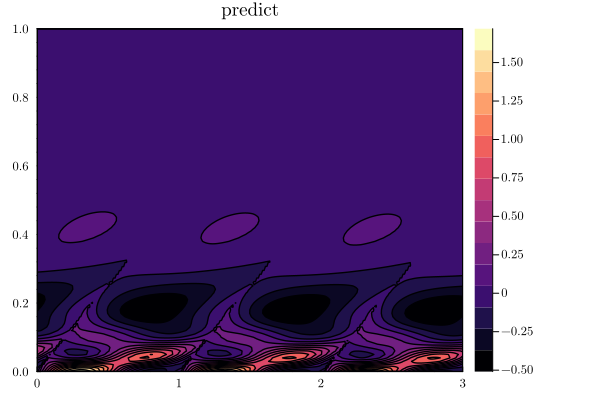

In [ ]:

# u_predict = reshape([first(phi([t,x],res.u)) for t in ts for x in xs],(length(xs),length(ts)))
u_predict = [[phi[i]([t,x],minimizers_[i])[1] for t in ts  for x in xs] for i in 1:2]
# u_real = reshape([analytic_sol_func(t,x) for t in ts for x in xs], (length(ts),length(xs)))
plot(ts, xs, u_predict[1], linetype=:contourf,title = "predict")

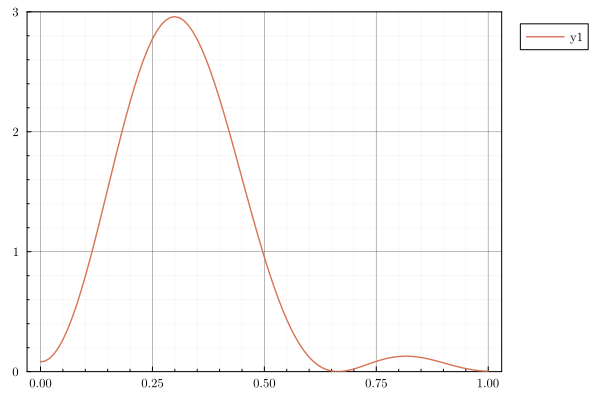

In [38]:
let t = 0.0
    plot(xs,[phi[1]([t,x],minimizers_[1])[1]^2 + phi[2]([t,x],minimizers_[2])[1]^2 for x in xs],ylim=(0,3))
end